# Setup

In [1]:
from scipy.io import loadmat
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt

In [52]:
data = loadmat('ex3data1.mat')
X, y = data['X'], data['y'].ravel()

# recode 10 to 0 - Matlab is 1-indexed
y[y == 10] = 0

m = y.size

# 10 labels, from 1 to 10 (note that we have mapped "0" to label 10)
num_labels = 10

In [3]:
# function to plot the pixel data
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data stored in X in a nice grid.
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = plt.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')

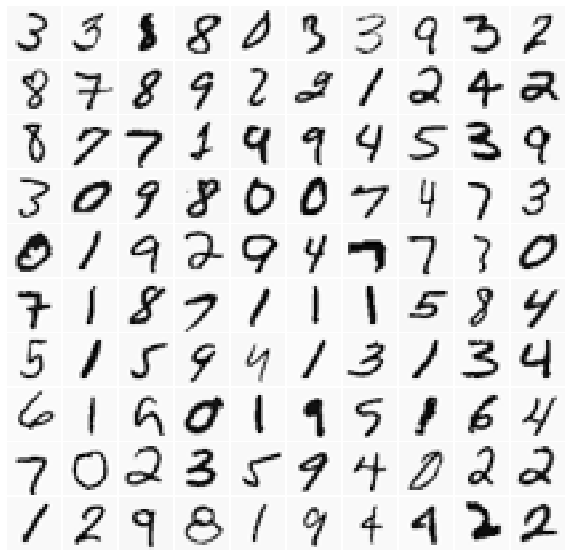

In [53]:
# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

displayData(sel)

# Logistic Regression

In [54]:
def sigmoid(z):
    """
    Computes the sigmoid of z.
    """
    return 1.0 / (1.0 + np.exp(-z))

In [55]:
def lrCostFunction(theta, X, y, lambda_):
    
    #Initialize some useful values
    m = y.size
    
    # convert labels to ints if their type is bool
    if y.dtype == bool:
        y = y.astype(int)
    
    # You need to return the following variables correctly
    J = 0
    grad = np.zeros(theta.shape)
    
    # ====================== YOUR CODE HERE ======================
    h = sigmoid(np.dot(X, theta))
    
    temp = theta
    temp[0] = 0

    J = (1/m) * np.sum(np.dot(-y, np.log(h)) - np.dot((1-y),np.log(1-h))) + lambda_ / (2*m) * np.sum(np.square(temp))
    
    grad = (1 / m) * (h - y).dot(X) 
    grad = grad + (lambda_ / m) * temp

    # =============================================================
    return J, grad

In [56]:
# test values for the parameters theta
theta_t = np.array([-2, -1, 1, 2], dtype=float)

# test values for the inputs
X_t = np.concatenate([np.ones((5, 1)), np.arange(1, 16).reshape(5, 3, order='F')/10.0], axis=1)

# test values for the labels
y_t = np.array([1, 0, 1, 0, 1])

# test value for the regularization parameter
lambda_t = 3

In [57]:
# test regression - results are off, but I think the problem is the data creation step
J, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)

print('Cost         : {:.6f}'.format(J))
print('Expected cost: 2.534819')
print('-----------------------')
print('Gradients:')
print(' [{:.6f}, {:.6f}, {:.6f}, {:.6f}]'.format(*grad))
print('Expected gradients:')
print(' [0.146561, -0.548558, 0.724722, 1.398003]');

Cost         : 2.534819
Expected cost: 2.534819
-----------------------
Gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]
Expected gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]


# One vs. All Classification

In [58]:
def oneVsAll(X, y, num_labels, lambda_):
    
    # Some useful variables
    m, n = X.shape
    
    # You need to return the following variables correctly 
    all_theta = np.zeros((num_labels, n + 1))

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    # ====================== YOUR CODE HERE ======================
    for c in np.arange(num_labels):
        initial_theta = np.zeros(n + 1)
        options = {'maxiter': 50}
        res = optimize.minimize(lrCostFunction, 
                                initial_theta, 
                                (X, (y == c), lambda_), 
                                jac=True, 
                                method='CG',
                                options=options) 
        
        all_theta[c] = res.x

    # ============================================================
    return all_theta

In [59]:
lambda_ = 0.1
all_theta = oneVsAll(X, y, num_labels, lambda_)

In [60]:
def predictOneVsAll(all_theta, X):
    m = X.shape[0];
    num_labels = all_theta.shape[0]

    p = np.zeros(m)

    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    p = np.argmax(sigmoid(X.dot(all_theta.T)), axis = 1)

    return p

In [63]:
# test accuracy - looks good
pred = predictOneVsAll(all_theta, X)
print('Training Set Accuracy: {:.2f}%'.format(np.mean(pred == y) * 100))

Training Set Accuracy: 95.04%


# Neural Networks

In [73]:
# set parameters for nn
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10

weights = loadmat('ex3weights.mat')

Theta1, Theta2 = weights['Theta1'], weights['Theta2']

#reindex for python
Theta2 = np.roll(Theta2, 1, axis=0)

indices = np.random.permutation(m)

In [66]:
Theta1.shape

(25, 401)

In [71]:
# create function for forward propagation
def predict(Theta1, Theta2, X):
    # Make sure the input has two dimensions
    if X.ndim == 1:
        X = X[None]  # promote to 2-dimensions
    
    m = X.shape[0]
    num_labels = Theta2.shape[0]

    p = np.zeros(X.shape[0])

    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    a2 = sigmoid(X.dot(Theta1.T))
    a2 = np.concatenate([np.ones((a2.shape[0], 1)), a2], axis=1)

    p = np.argmax(sigmoid(a2.dot(Theta2.T)), axis = 1)

    return p


In [72]:
# check prediction accuracy
pred = predict(Theta1, Theta2, X)
print('Training Set Accuracy: {:.1f}%'.format(np.mean(pred == y) * 100))

Training Set Accuracy: 97.5%


Neural Network Prediction: 6


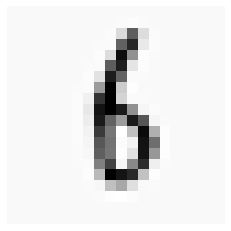

In [77]:
# check predictions for individual pixels
if indices.size > 0:
    i, indices = indices[0], indices[1:]
    displayData(X[i, :], figsize=(4, 4))
    pred = predict(Theta1, Theta2, X[i, :])
    print('Neural Network Prediction: {}'.format(*pred))
else:
    print('No more images to display!')